## Installing uv

To start, you'll want to have uv installed:

https://docs.astral.sh/uv/getting-started/installation/


**Next, run this in the terminal, from the parent directory:**

    uv sync


Now you will have the kernel used to run this notebook

---

## Running the Required Servers

You need to run **three servers**, each in its own terminal:

- `central_server.py`
- `AS_server_AtomBlastTwin.py`
- `Ceos_server_twin.py`

### 1. Activate the Virtual Environment

`uv` should have created a `.venv` directory for you.

**On macOS / Linux:**

    source .venv/bin/activate

**On Windows (likely):**

    source .venv/Scripts/activate

You should now see the environment activated.

---

### 2. Start the Servers

**Terminal 1 — Central Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.protocols.central_server

**Terminal 2 — Atom Resolution Simulation Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.AS_server_AtomBlastTwin

**Terminal 3 — CEOS Twin Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.Ceos_server_twin

---

You're now ready to run this notebook! 🚀

In [1]:
import sys
import ast
import numpy as np
sys.path.insert(0, '../')
from asyncroscopy.clients.notebook_client import NotebookClient
from asyncroscopy.utils import parula_color_map
import matplotlib.pyplot as plt

from skimage.feature import blob_log
from scipy.ndimage import gaussian_filter

import pyTEMlib
from pyTEMlib import probe_tools as pt
from pyTEMlib.atom_tools import atom_refine
%matplotlib ipympl

### Connections:

In [2]:
# Connect the Client to the central (async) server
tem = NotebookClient.connect(host='localhost',port=9000)

# Tell the central server address of all connected instruments
routing_table= {"AS": ("localhost", 9001),
                "Gatan": ("localhost", 9002),
                "Ceos": ("localhost", 9003),
                "Preacquired_AS": ("localhost", 9004)}
tem.send_command('Central',"set_routing_table", routing_table)

# ConnectionResetError: [Errno 54] Connection reset by peer 
# in terminal, type:
# lsof -i :9000
# then kill PIDs on that port


Connecting to central server localhost:9000...
Connected to central server.


'[Central] Routing table updated'

In [3]:
# connect to the AutoScript computer and initialize microscope
tem.send_command('AS',command='connect_AS',args={'host':'localhost','port':9001})
tem.send_command(destination = 'Ceos', command = 'getInfo', args = {})

'CEOS Digital Twin Server'

### Help commands:

In [4]:
# Now that we're routed to all instruments,
# let's take an inventory of commands available on each instrument
cmds = tem.send_command('AS', 'discover_commands')
print(cmds)

["blank_beam", "connect_AS", "connectionLost", "connectionMade", "dataReceived", "disconnect", "discover_commands", "get_atom_count", "get_dose_map", "get_help", "get_scanned_image", "get_stage", "get_status", "lengthLimitExceeded", "load_sample", "logPrefix", "makeConnection", "pauseProducing", "place_beam", "reset_sample", "resumeProducing", "sendString", "set_beam_current", "set_fov", "stopProducing", "stringReceived", "unblank_beam"]


### Setting the aberrations from known values:

In [123]:
aberrations = pt.get_target_aberrations("Spectra300", 200000)
aberrations['C23a'] = 10
aberrations['C23b'] = 10
tem.send_command(destination = 'Ceos', command = 'uploadAberrations', args = aberrations)

'Aberrations Loaded'

### Get an image:

simulated with pystemsim inside the AS_server_SimAtomRes (working with the Ceos server)

In [132]:
tem.send_command('AS', 'load_sample')

'Loaded sample with 3600 atoms. Dose map initialized.'

'Current atom count: 3600'

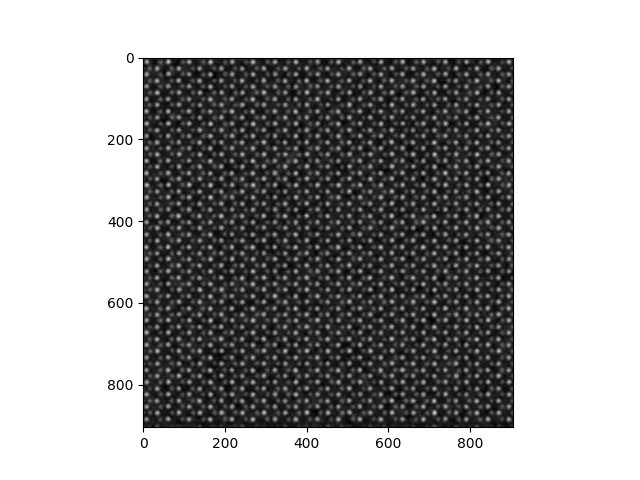

In [133]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':10e-6}

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img, cmap="gray")
tem.send_command('AS', 'get_atom_count', {})

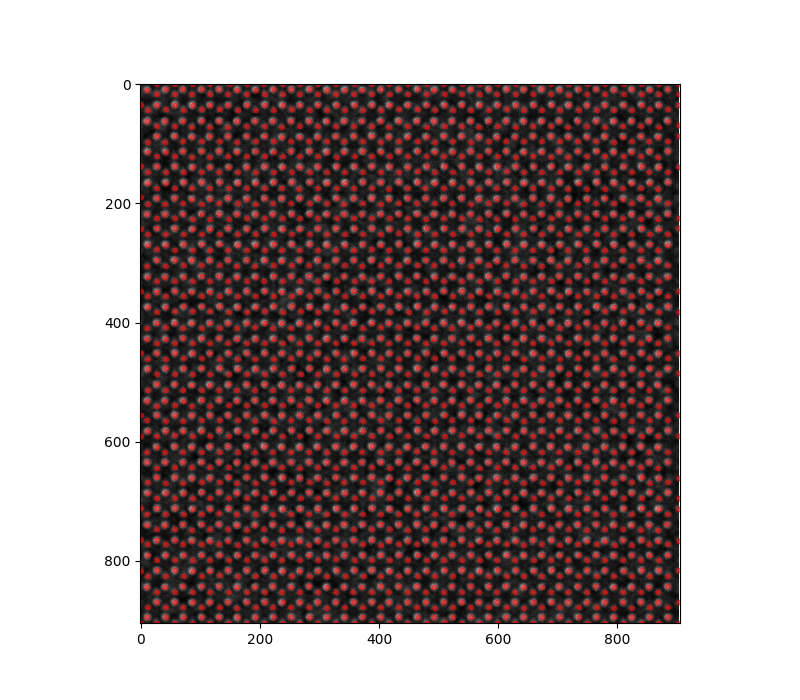

In [134]:
# get atoms
blurred = gaussian_filter(img, sigma=1)
blobs = blob_log(blurred, max_sigma=3, threshold=0.05)

fig, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
ax.imshow(img.T, cmap='gray')
ax.scatter(blobs[:, 0], blobs[:, 1], c='r', s=10, alpha = .5)

In [135]:
# refine atoms
atom_radius = 3  # in pixel
sym = atom_refine(img, blobs, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])
intensities = np.array(sym['intensity_area'])

to_delete = np.where(intensities < 0)
refined_atoms = np.delete(refined_atoms, to_delete, axis=0)
intensities = np.delete(intensities, to_delete, axis=0)

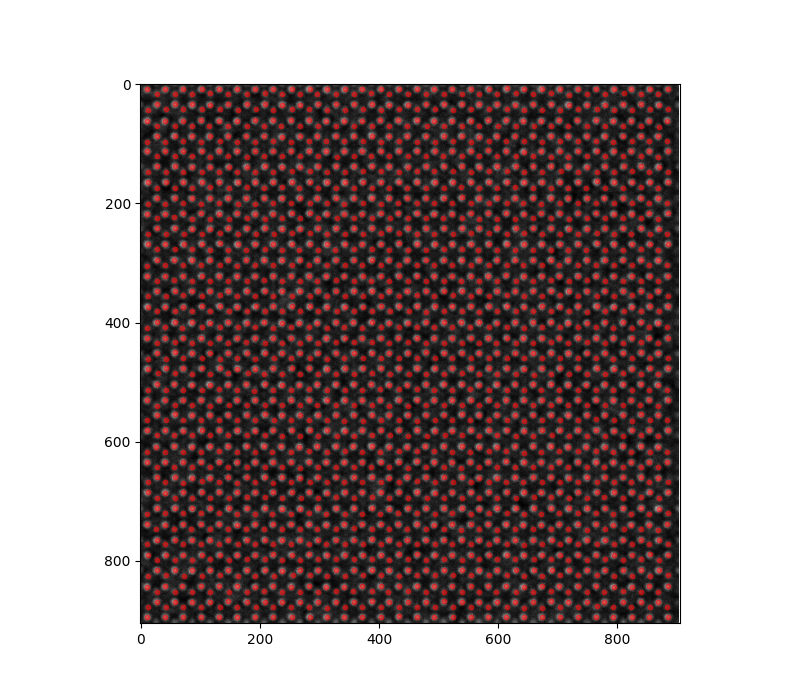

In [136]:
fig, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
ax.imshow(img.T, cmap='gray')
ax.scatter(refined_atoms[:, 0], refined_atoms[:, 1], c='r', s=10, alpha = .5)

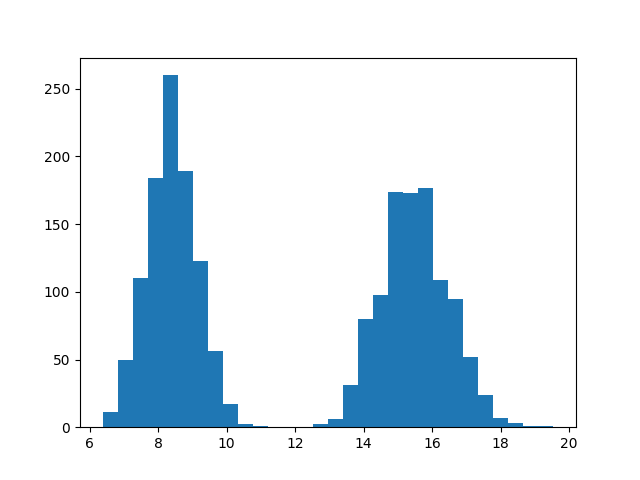

In [137]:
plt.figure()
plt.hist(intensities, bins=30);

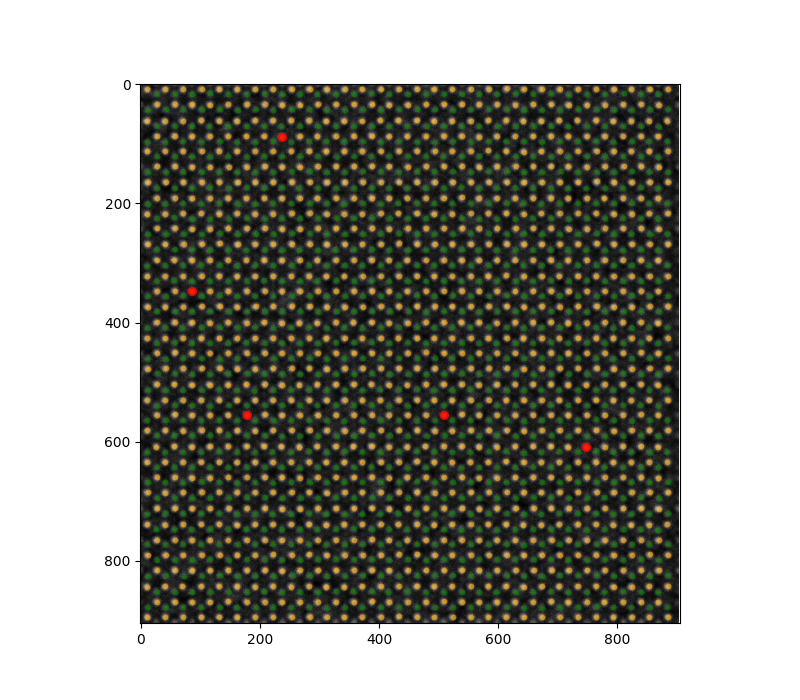

In [138]:
cutoff = 11

metal_atoms = refined_atoms[intensities > cutoff]
chalcogen_atoms = refined_atoms[intensities <= cutoff]

# randomly select metal atoms
edge_margin = 60      # pixels from image edge
min_separation = 100   # minimum distance between targets (pixels)
n_targets = 5

h, w = img.shape
x = metal_atoms[:, 0]
y = metal_atoms[:, 1]
interior_mask = ((x > edge_margin) & (x < w - edge_margin) & (y > edge_margin) & (y < h - edge_margin))
candidates = metal_atoms[interior_mask]
def select_separated(points, n, min_dist):
    selected = []
    idx = np.random.permutation(len(points))
    for i in idx:
        p = points[i]
        if all(np.linalg.norm(p - q) >= min_dist for q in selected):
            selected.append(p)
        if len(selected) == n:
            break
    return np.array(selected)
targets = select_separated(candidates, n=n_targets, min_dist=min_separation)

fig, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
ax.imshow(img.T, cmap='gray')
ax.scatter(metal_atoms[:, 0], metal_atoms[:, 1], c='orange', s=10, alpha = .5, label='Metal atoms')
ax.scatter(chalcogen_atoms[:, 0], chalcogen_atoms[:, 1], c='g', s=10, alpha = .5, label='Chalcogen atoms')
ax.scatter(targets[:, 0], targets[:, 1], c='r', s=30, alpha = .8, label='Target atoms')

Frame 1/10
Frame 2/10
Frame 3/10
Frame 4/10
Frame 5/10
Frame 6/10
Frame 7/10
Frame 8/10
Frame 9/10
Frame 10/10


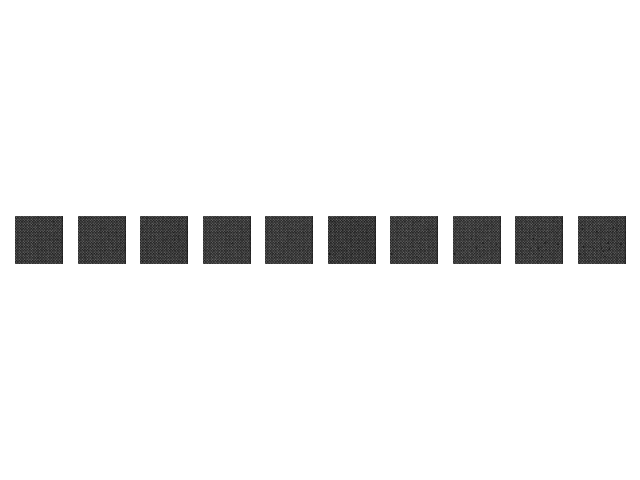

In [139]:
n_frames = 10
blast_duration = 0.1      # seconds
blast_current = 10    # pA
imaging_current = 10      # pA

img_h, img_w = img.shape
beam_positions = np.column_stack([targets[:, 1] / img_w, targets[:, 0] / img_h,])

fig, ax = plt.subplots(1,10)
intensities_over_time = []
for frame in range(n_frames):
    print(f"Frame {frame+1}/{n_frames}")

    # ZAP
    tem.send_command('AS', 'set_beam_current', {'current': blast_current})
    for bx, by in beam_positions:
        tem.send_command('AS', 'place_beam', {'x': bx, 'y': by})
        tem.send_command('AS', 'unblank_beam', {'duration': blast_duration})

    # Image after batch
    tem.send_command('AS', 'set_beam_current', {'current': imaging_current})
    img = tem.send_command('AS', 'get_scanned_image', image_args)
    ax[frame].imshow(img.T, cmap='gray')
    ax[frame].axis('off')
    # Refine atoms & extract intensities
    sym = atom_refine(img,targets,atom_radius,max_int=0,min_int=0,max_dist=2)
    refined_atoms = np.array(sym['atoms'])
    intensities = np.array(sym['intensity_area'])
    intensities_over_time.append(intensities)
fig.tight_layout()




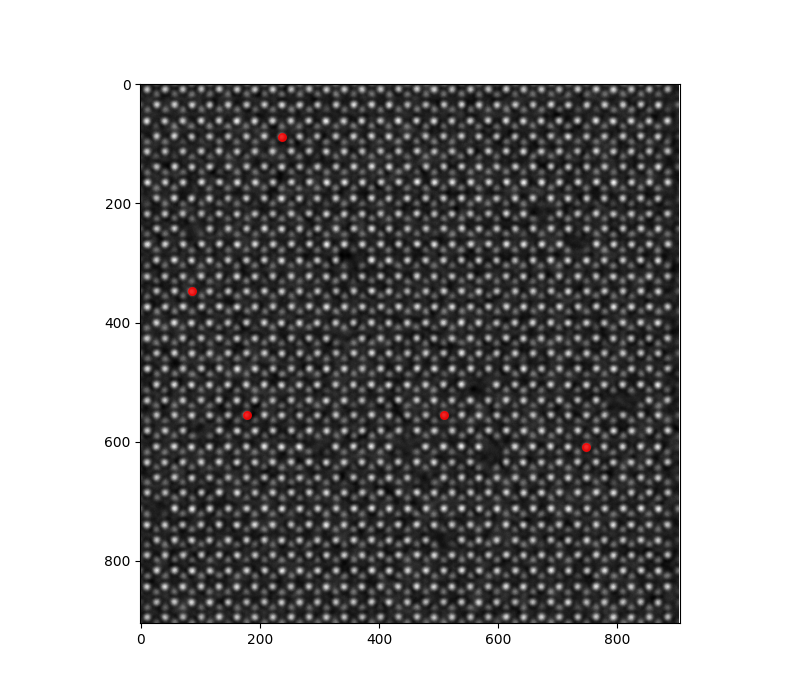

In [144]:
fig, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
ax.imshow(img.T, cmap='gray')
# ax.scatter(metal_atoms[:, 0], metal_atoms[:, 1], c='orange', s=10, alpha = .5, label='Metal atoms')
# ax.scatter(chalcogen_atoms[:, 0], chalcogen_atoms[:, 1], c='g', s=10, alpha = .5, label='Chalcogen atoms')
ax.scatter(targets[:, 0], targets[:, 1], c='r', s=30, alpha = .8, label='Target atoms')

In [140]:
intensities_over_time = np.array(intensities_over_time)
intensities_over_time.shape

(10, 5)

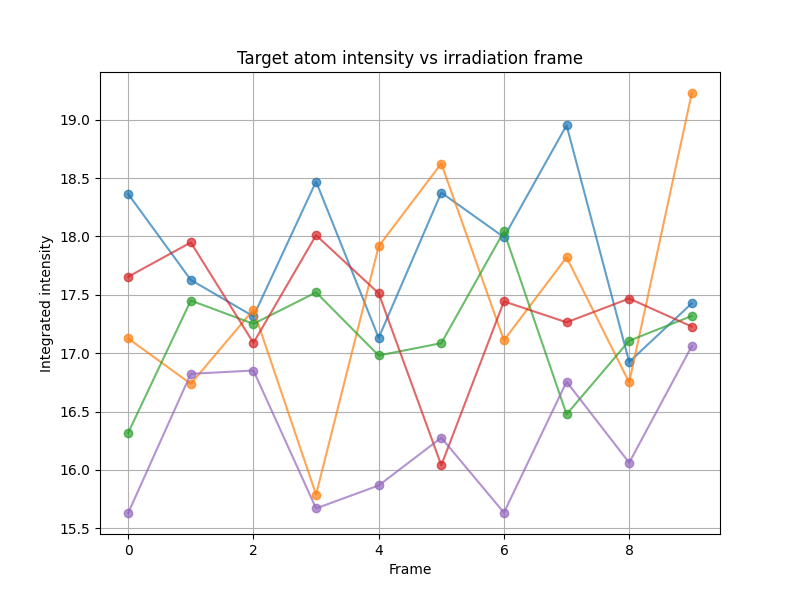

In [141]:
plt.figure(figsize=(8,6))

for i in range(n_targets):
    plt.plot(np.arange(n_frames),intensities_over_time[:, i],'-o',alpha=0.7)

plt.xlabel("Frame")
plt.ylabel("Integrated intensity")
plt.title("Target atom intensity vs irradiation frame")
plt.grid(True)

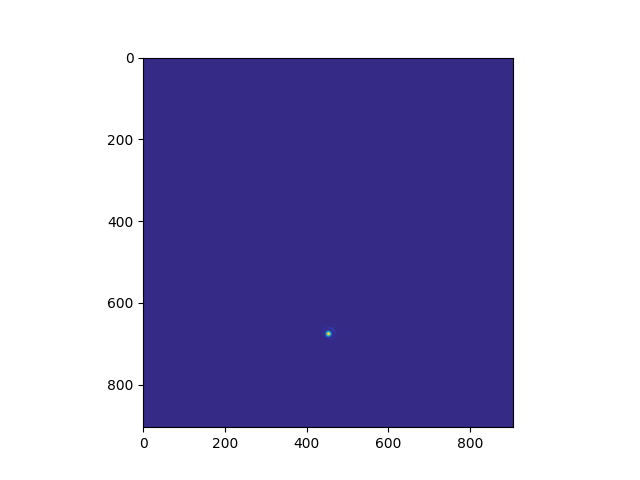

In [9]:
dose_map = tem.send_command('AS', 'get_dose_map', {})

plt.figure()
plt.imshow(dose_map, cmap=parula_color_map)

In [10]:
tem.send_command(destination = 'Ceos', command = 'correctAberration', args = {"name": 'C10', "value": -5})

'Aberration C10 changed to -5.0'

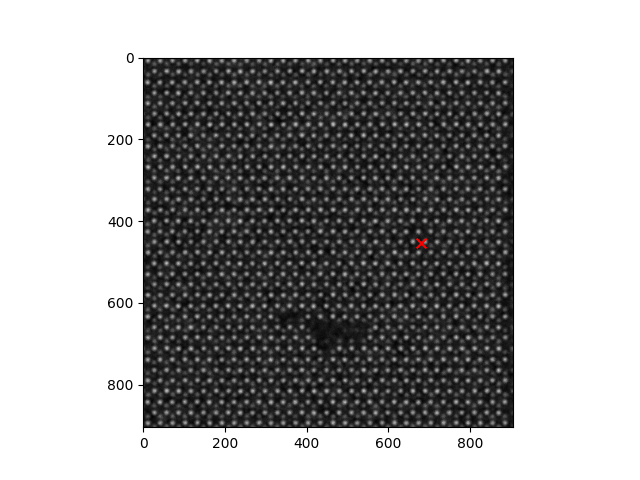

In [11]:
# Position beam and expose
beam_pos = [0.5, 0.75]

beam_current = 2000
tem.send_command('AS', 'place_beam', {'x': beam_pos[1], 'y': beam_pos[0]})
tem.send_command('AS', 'set_beam_current', {'current': beam_current})
tem.send_command('AS', 'unblank_beam', {'duration': 10}) # seconds

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
tem.send_command(destination = 'Ceos', command = 'correctAberration', args = {"name": 'C10', "value": 0})
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img.T, cmap="gray")
plt.scatter(beam_pos[1] * img.shape[1], beam_pos[0] * img.shape[0], color='red', s=50, marker='x')


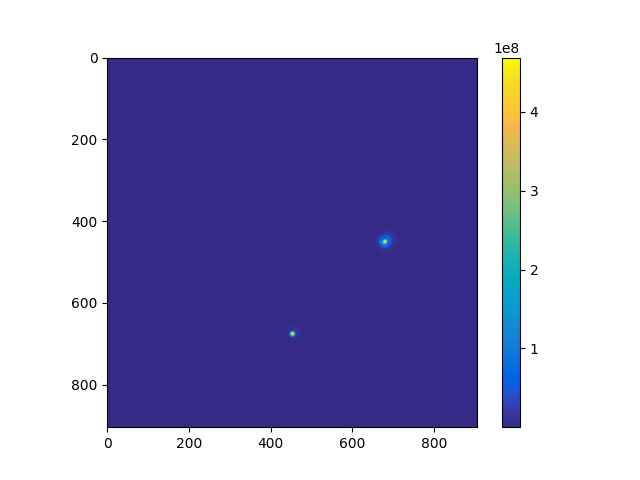

In [12]:
dose_map = tem.send_command('AS', 'get_dose_map', {})

plt.figure()
plt.imshow(dose_map, cmap=parula_color_map)
plt.colorbar()


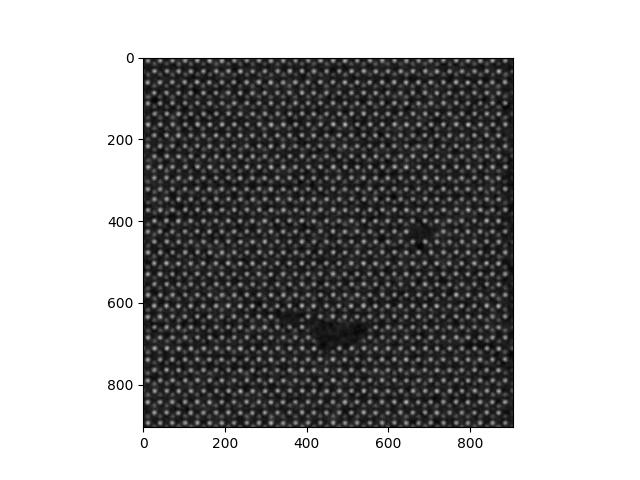

In [13]:
beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img.T, cmap="gray")
